# Movie Recommender

In this notebook, you will learn how to use PySpark to make personalized movie recommendations using the [Movielens](https://grouplens.org/datasets/movielens/) data.

![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png) ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)

## Data processing

In [2]:
import os
import urllib.request
import zipfile
import numpy as np

In [3]:
# Small dataset
# 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users. 
# Last updated 10/2016.
dataset_url = 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'

In [4]:
datasets_path = '/Users/Honglei/Desktop/'
small_dataset_path = os.path.join(datasets_path, 'ml-latest-small.zip')
small_f = urllib.request.urlretrieve (dataset_url, small_dataset_path)

In [5]:
with zipfile.ZipFile(small_dataset_path, "r") as z:
    z.extractall(datasets_path)

## Parsing data

In [6]:
small_ratings_file = os.path.join(datasets_path, 'ml-latest-small', 'ratings.csv')

In [7]:
# import PySpark modules
import findspark
findspark.init()

from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.recommendation import ALS
#from pyspark.mllib.recommendation import ALS (different!)

from pyspark.sql import functions as F

### RDD

In [8]:
!pyspark --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 2.2.0
      /_/
                        
Using Scala version 2.11.8, Java HotSpot(TM) 64-Bit Server VM, 1.8.0_144
Branch 
Compiled by user jenkins on 2017-06-30T22:58:04Z
Revision 
Url 
Type --help for more information.


In [9]:
spark = SparkSession \
    .builder \
    .appName("Movie recommendation") \
    .getOrCreate()
    

ratings_df = spark.read.option("header", "true").csv(small_ratings_file)

### check the first 3 rows

In [10]:
ratings_df.show(3)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
+------+-------+------+----------+
only showing top 3 rows



### select columns 

In [11]:
ratings_df = ratings_df.select(col("userId"), col("movieId"), col("rating"))

In [12]:
print(ratings_df.schema)

StructType(List(StructField(userId,StringType,true),StructField(movieId,StringType,true),StructField(rating,StringType,true)))


### filter out movies with very few (`<`10) reviews

In [13]:
movie_ids_with_avg_ratings_df = ratings_df.groupBy('movieId').\
                agg(F.count(ratings_df.rating).alias("count"), F.avg(ratings_df.rating).alias("average"))
    
movie_ids_with_avg_ratings_df.show(3)

+-------+-----+------------------+
|movieId|count|           average|
+-------+-----+------------------+
|   2294|   53|3.2735849056603774|
|    296|  324| 4.256172839506172|
|   3210|   52|3.6153846153846154|
+-------+-----+------------------+
only showing top 3 rows



In [14]:
movies_with_10_ratings_or_more = movie_ids_with_avg_ratings_df.filter("count>=10")
movies_with_10_ratings_or_more = movies_with_10_ratings_or_more.sort(movies_with_10_ratings_or_more.average, ascending = False)
print ('Movies with top 5 highest ratings:')

movies_with_10_ratings_or_more.show(5, truncate = False) 

Movies with top 5 highest ratings:
+-------+-----+-----------------+
|movieId|count|average          |
+-------+-----+-----------------+
|1939   |11   |4.636363636363637|
|3469   |12   |4.541666666666667|
|858    |200  |4.4875           |
|318    |311  |4.487138263665595|
|1948   |12   |4.458333333333333|
+-------+-----+-----------------+
only showing top 5 rows



In [15]:
# merge with ratings_df
ratings_df = movies_with_10_ratings_or_more.join(ratings_df, "movieId", "inner")

In [16]:
ratings_df.show(3)

+-------+-----+-----------------+------+------+
|movieId|count|          average|userId|rating|
+-------+-----+-----------------+------+------+
|   1939|   11|4.636363636363637|   547|   5.0|
|   1939|   11|4.636363636363637|   505|   3.0|
|   1939|   11|4.636363636363637|   468|   3.0|
+-------+-----+-----------------+------+------+
only showing top 3 rows



In [17]:
ratings_df = ratings_df.select(col("userId"), col("movieId"), col("rating"))

### need to change `rating`'s type to `Double`

In [18]:
ratings_df = ratings_df.withColumn("rating", ratings_df["rating"].cast(DoubleType()))
ratings_df = ratings_df.withColumn("movieId", ratings_df["movieId"].cast(DoubleType()))
ratings_df = ratings_df.withColumn("userId", ratings_df["userId"].cast(DoubleType()))

### cache the rating dataframe

In [19]:
ratings_df.cache()
assert ratings_df.is_cached

### split data into training, validation and testing

In [20]:
# hold out 60% for training, 20% for validation, and leave 20% for testing
seed = 2017
(split_60_df, split_a_20_df, split_b_20_df) = ratings_df.randomSplit([0.6,0.2,0.2], seed)

# cache these datasets for performance
training_df = split_60_df.cache()
validation_df = split_a_20_df.cache()
test_df = split_b_20_df.cache()

### print how many rows in training, validation and testing dataset

In [21]:
print('Training: {0}, validation: {1}, test: {2}\n'.format(training_df.count(), \
                                                           validation_df.count(), \
                                                           test_df.count()))

Training: 48985, validation: 16603, test: 16327



## Baseline Model

In [22]:
# RMSE evaluator using the label and predicted columns
reg_eval = RegressionEvaluator(predictionCol = "prediction", labelCol = "rating", metricName = "rmse")

In [23]:
training_avg_rating = training_df.agg(avg(training_df.rating)).collect()[0][0]
print('The average rating for movies in the training set is {0}'.format(training_avg_rating))

# add a column with the average rating
test_for_avg_df = test_df.withColumn('prediction', F.lit(training_avg_rating))

The average rating for movies in the training set is 3.607604368684291


In [25]:
# get RMSE
test_avg_RMSE = reg_eval.evaluate(test_for_avg_df)
print("The baseline RMSE is {0}".format(test_avg_RMSE))

The baseline RMSE is 1.0321943115352572


## Collaborative Filtering

<img src="https://courses.edx.org/c4x/BerkeleyX/CS100.1x/asset/Collaborative_filtering.gif" alt="collaborative filtering" style="float: right"/>
At first, people rate different items (like videos, images, games). After that, the system is making predictions about a user's rating for an item, which the user has not rated yet. These predictions are built upon the existing ratings of other users, who have similar ratings with the active user. For instance, in the image below the system has made a prediction, that the active user will not like the video.

<br clear="all"/>

----


<img alt="factorization" src="http://spark-mooc.github.io/web-assets/images/matrix_factorization.png" style="width: 885px"/>
<br clear="all"/>

Spark provides a Collaborative Filtering implementation by using **Alternating Least Squares**. The implementation has the following parameters:

- `rank` is the number of latent factors in the model.
- `iterations` is the number of iterations to run.
- `regParam` specifies the regularization parameter in ALS.


[als]: https://en.wikiversity.org/wiki/Least-Squares_Method
[mllib]: http://spark.apache.org/docs/latest/mllib-guide.html
[collab]: https://en.wikipedia.org/?title=Collaborative_filtering
[collab2]: http://recommender-systems.org/collaborative-filtering/

### *[PySpark](http://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html?highlight=als#pyspark.ml.recommendation.ALS)*
`class pyspark.ml.recommendation.ALS(self, 
rank=10, maxIter=10, regParam=0.1, numUserBlocks=10, numItemBlocks=10, 
implicitPrefs=false, alpha=1.0, userCol="user", itemCol="item", seed=None, 
ratingCol="rating", nonnegative=false, checkpointInterval=10, 
intermediateStorageLevel="MEMORY_AND_DISK", finalStorageLevel="MEMORY_AND_DISK", 
coldStartStrategy="nan")`

In [26]:
def train_ALS(rank, maxit, reg, train_df, test_df, seed = 2017):
    als = ALS(maxIter = maxit, 
              regParam = reg,
              rank = rank,
              userCol = "userId", 
              itemCol = "movieId", 
              ratingCol = "rating",
              coldStartStrategy = "drop")
    
    # set the parameters for the method
    als.setSeed(seed)
    
    # Create the model with these parameters.
    model = als.fit(train_df)
    # Run the model to create a prediction. Predict against the validation_df.
    predict_df = model.transform(test_df)
    error = reg_eval.evaluate(predict_df)
    # In-sample error
    predict_in_df = model.transform(train_df)
    in_error = reg_eval.evaluate(predict_in_df) 
    
    # print 
    print ("Using number of ranks = ", rank)
    print ("Using number of iterations = ", maxit)
    print ("Using Reg para = ", reg)
    print ("Training dataset RMSE = ", in_error, '\n')
    print ("Validation dataset RMSE = ", error, '\n')
    return(error)

In [27]:
#predicted_ratings_df = predict_df.filter(predict_df.prediction != float('nan'))

## Parameters grid search

In [28]:
numIterations = [5, 10]
ranks = [2, 4]
regs = list(np.arange(0.05, 0.3, 0.05))

RMSE_results = []

for rank in ranks:
    for maxit in numIterations:
        for reg in regs:
            RMSE_results.append(train_ALS(rank = rank, maxit = maxit, reg = reg, \
                                          train_df = training_df, test_df = validation_df))

Using number of ranks =  2
Using number of iterations =  5
Using Reg para =  0.05
Training dataset RMSE =  0.7625177224763114 

Validation dataset RMSE =  0.8951757528553103 

Using number of ranks =  2
Using number of iterations =  5
Using Reg para =  0.1
Training dataset RMSE =  0.7739964699942851 

Validation dataset RMSE =  0.8882196692614659 

Using number of ranks =  2
Using number of iterations =  5
Using Reg para =  0.15
Training dataset RMSE =  0.7916275577953994 

Validation dataset RMSE =  0.891349598089707 

Using number of ranks =  2
Using number of iterations =  5
Using Reg para =  0.2
Training dataset RMSE =  0.8139607773959153 

Validation dataset RMSE =  0.9008125854459965 

Using number of ranks =  2
Using number of iterations =  5
Using Reg para =  0.25
Training dataset RMSE =  0.839648725554191 

Validation dataset RMSE =  0.9149382103091684 

Using number of ranks =  2
Using number of iterations =  10
Using Reg para =  0.05
Training dataset RMSE =  0.75967348345136

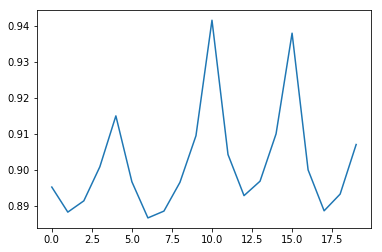

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(RMSE_results);

### Train with the optimal parameters and test on the testing dataset

In [31]:
#from pyspark.ml.recommendation import ALS
test_error = train_ALS(rank = 2, maxit = 10, reg = 0.1,\
                       train_df = training_df, test_df = test_df)
print("The ALS RMSE is {0}".format(test_error))

Using number of ranks =  2
Using number of iterations =  10
Using Reg para =  0.1
Training dataset RMSE =  0.7710646367494762 

Validation dataset RMSE =  0.8709988822513952 

The ALS RMSE is 0.8709988822513952


## Recommend myself some movies, go!

In [32]:
movies_file = os.path.join(datasets_path, 'ml-latest-small', 'movies.csv')

In [33]:
movies = spark.read.option("header", "true").csv(movies_file)
movies.show(3)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
+-------+--------------------+--------------------+
only showing top 3 rows



In [34]:
movies_titles = movies.rdd.map(lambda x: (int(x[0]),x[1]))
print ("There are %s movies in the small dataset" % (movies_titles.count()))

There are 9125 movies in the small dataset


In [35]:
movies_df = movies.drop('genres').withColumnRenamed('movieId', 'ID')

### find the movie ID based on names

In [36]:
my_movies = movies_df.filter("title like '%love%'")
my_movies.show()

+------+--------------------+
|    ID|               title|
+------+--------------------+
|    40|Cry, the Beloved ...|
|   249|Immortal Beloved ...|
|   750|Dr. Strangelove o...|
|  2314|      Beloved (1998)|
|  6433|Man with the Movi...|
|  6757|   Demonlover (2002)|
| 57368|  Cloverfield (2008)|
|152077|10 Cloverfield La...|
+------+--------------------+



Now I need to rate some movies for the myself. Let's use the user ID 0 for me as this is not assigned in the MovieLens dataset.

### Give some ratings

In [37]:
from pyspark.sql import Row
my_user_id = 0


# The format of each line is (userId, movieId, rating), rating scale is 0-5
my_ratings = [
     (0,260,1), # Star Wars (1977)
     (0,60950,5), # Vicky Cristina Barcelona (2008)
     (0,79132,5), # Inception (2010)
     (0,86882,5), # Midnight in Paris (2011)
     (0,318,5), # Shawshank Redemption, The (1994)
     (0,215,5), # Before Sunrise (1995)
     (0,8638,5), # Before Sunset (2004)
     (0,296,4), # Pulp Fiction (1994)
     (0,858,4) , # Godfather, The (1972)
     (0,33645,5), # Carol (2015)
     (0,4993,1), # Lord of the Rings: The Fellowship of the Ring, The (2001)
     (0, 995,4) # Beautiful Mind, A (2001)
    ]

In [38]:
my_ratings_df = spark.createDataFrame(my_ratings, ['userId','movieId','rating'])
print ('My movie ratings:')
my_ratings_df.show()

My movie ratings:
+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     0|    260|     1|
|     0|  60950|     5|
|     0|  79132|     5|
|     0|  86882|     5|
|     0|    318|     5|
|     0|    215|     5|
|     0|   8638|     5|
|     0|    296|     4|
|     0|    858|     4|
|     0|  33645|     5|
|     0|   4993|     1|
|     0|    995|     4|
+------+-------+------+



### Movies that I rated 5

![](files/sunrise.jpg)
![](files/sunset.jpeg)
![](files/Midnight.jpg)
![](files/download.jpg)
![](files/carol.jpg)

### Movies that I rated 1

![](files/The_Lord.jpg)
![](files/star.jpeg)

### add my ratings to the training dataset so that the model will incorporate my preferences

In [39]:
training_with_my_ratings_df = training_df.unionAll(my_ratings_df)

In [40]:
training_with_my_ratings_df.show(3)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|   3.0|  318.0|   5.0|
|   8.0|  318.0|   5.0|
|   9.0|  318.0|   4.0|
+------+-------+------+
only showing top 3 rows



## Train a Model with your ratings

In [43]:
als = ALS(maxIter = 10, regParam = 0.1, rank = 2, 
          userCol = "userId", itemCol = "movieId", 
          ratingCol = "rating", 
          coldStartStrategy = "drop")
als.setSeed(2017)
final_model = als.fit(training_with_my_ratings_df)

In [44]:
# a list of my rated movie IDs
my_rated_movie_ids = [x[1] for x in my_ratings]

# filter out the movies I already rated.
not_rated_df = movies_df.filter(~ movies_df['ID'].isin(my_rated_movie_ids))

In [45]:
# rename the "ID" column to be "movieId", and add a column with my_user_id as "userId".
my_unrated_movies_df = not_rated_df.withColumn("userId", F.lit(my_user_id)).withColumnRenamed("ID","movieId")

In [46]:
my_unrated_movies_df = my_unrated_movies_df.withColumn("movieId", my_unrated_movies_df["movieId"].cast(DoubleType()))

In [49]:
# use my_rating_model to predict ratings for the movies that I did not manually rate.
predictions = final_model.transform(my_unrated_movies_df)
predicted_highest_rated_movies_df = predictions.sort(predictions.prediction,ascending = False)

print ('My 5 highest rated movies as predicted:')
predicted_highest_rated_movies_df.select('title').show(5, truncate = False)

My 5 highest rated movies as predicted:
+-------------------------------+
|title                          |
+-------------------------------+
|Squid and the Whale, The (2005)|
|Bounce (2000)                  |
|My Own Private Idaho (1991)    |
|Madonna: Truth or Dare (1991)  |
|Reds (1981)                    |
+-------------------------------+
only showing top 5 rows



## Recommended moview for me
![](files/Whale.png)

![](files/bounce.jpeg)